In [1]:
%pylab inline
import pylab
import seaborn as sns

import numpy as np
import nengolib

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
from random import random

import nengo
from nengo.params import NumberParam, Default
from nengo.synapses import SynapseParam

from nengolib.network import Network
from nengolib.signal.normalization import HankelNorm as default_normalizer
from nengolib.signal.system import LinearSystem, is_exp_stable
from nengolib.synapses.mapping import ss2sim


class DistBootstrapper(nengo.dists.Distribution):
    
    def __init__(self, sampler, *args, **kwargs):
        self._sampler = sampler
        super(DistBootstrapper, self).__init__(*args, **kwargs)
    
    def sample(self, *args, **kwargs):
        return self._sampler(self, *args, **kwargs)


class ControlledLinearNetwork(Network):
    """Linear time-invariant (LTI) system with a gain control."""

    synapse = SynapseParam('synapse')
    input_synapse = SynapseParam('input_synapse')
    dt = NumberParam('dt', low=0, low_open=True, optional=True)

    def __init__(self, sys, n_neurons, synapse, dt, radii=1.0, control_radius=1.0,
                 input_synapse=Default, normalizer=default_normalizer(),
                 solver=Default, label=None, seed=None, add_to_container=None,
                 **ens_kwargs):
        super(ControlledLinearNetwork, self).__init__(label, seed, add_to_container)

        # Parameter checking
        self.sys = LinearSystem(sys)
        self.n_neurons = n_neurons
        self.synapse = synapse
        self.input_synapse = (synapse if input_synapse is Default
                              else input_synapse)
        self.dt = dt
        self.radii = radii
        self.normalizer = normalizer

        if not is_exp_stable(self.sys):
            # This means certain normalizers won't work, because the worst-case
            # output is now unbounded.
            warnings.warn("system (%s) is not exponentially stable" % self.sys)

        # Obtain a normalized state-space representation
        self.normalized, self.info = self.normalizer(self.sys, self.radii)
        self.A, self.B, self.C, self.D = ss2sim(
            self.normalized, self.synapse, self.dt).ss

        self.size_in = self.B.shape[1]
        self.size_state = len(self.A)
        self.size_out = len(self.C)
        
        def recurrent_function(x):
            c = control_radius*x[-1]
            x = x[:-1]
            return (1 + c) * np.dot(self.A, x) - c * x
        
        def output_function(x):
            c = control_radius*x[-1]
            x = x[:-1]
            return np.dot(self.C, x) * (1 + c)
        
        def sample_encoders(_dist, n, d=1, rng=np.random):
            # use product encoders on last dimension paired with another random dimension
            r = np.zeros((n, d))
            for i in range(n):
                r[i, rng.choice(d - 1)] = rng.choice((-1, 1))
                r[i, -1] = rng.choice((-1, 1))
            return r
        
        encoders = DistBootstrapper(sample_encoders)
        eval_points = nengo.dists.Uniform(-1, 1)  # hypercube
        
        with self:
            # Create internal Nengo objects
            self.input = nengo.Node(size_in=self.size_in, label="input")
            self.output = nengo.Node(size_in=self.size_out, label="output")
            self.control = nengo.Node(size_in=1, label="control")
            
            # This is effectively a product network (ensemble array) where the
            # last dimension (control) is paired elementwise with every other dimension (x).
            # We do it as such so that the decoders are optimized over all neurons simultaneously,
            # since each of the sub-ensembles are correlated. The radius is sqrt(2) because each neuron
            # represents two dimensions that have been normalized to be in the range (-1, 1).
            # The eval points are taken from the hypercube because all of the input dimensions are treated
            # as independent, while the encoders are taken from the classical product network.
            # The eval points should not be scaled by the radius, and so scale_eval_points=False is
            # passed to each outgoing connection.
            self.x = nengo.Ensemble(
                self.n_neurons, self.size_state+1, encoders=encoders, eval_points=eval_points,
                radius=np.sqrt(2), **ens_kwargs)
    
            if solver is not Default:
                # https://github.com/nengo/nengo/issues/1044
                assert not hasattr(solver, '_hack')
                solver._hack = random()
                
            # Connect everything up using (A, B, C, D)
            nengo.Connection(
                self.control, self.x[-1], transform=1.0 / control_radius, synapse=None)
            self.conn_A = nengo.Connection(
                self.x, self.x[:-1], function=recurrent_function, synapse=self.synapse,
                solver=solver, scale_eval_points=False)
            self.conn_B = nengo.Connection(
                self.input, self.x[:-1], transform=self.B,
                synapse=self.input_synapse)
            self.conn_C = nengo.Connection(
                self.x, self.output, function=output_function, synapse=None,
                solver=solver, scale_eval_points=False)
            self.conn_D = nengo.Connection(
                self.input, self.output, transform=self.D, synapse=None)

In [3]:
from nengo.dists import Gaussian
from nengo.processes import PresentInput, WhiteSignal
from nengo.solvers import LstsqL2

from nengolib.networks import Reservoir
from nengolib.synapses import PadeDelay

dt = 0.0001
neuron_type = nengolib.PerfectLIF()  # nengo.Direct()
synapse = 0.05

In [4]:
seed = 2

hz = 5
delay = 0.05

diffs = np.asarray([-0.025, 0.000, 0.025, 0.050, 0.075, 0.100])
gains = delay / (delay + diffs) - 1  # convert time difference to inverse gain
period = 0.5

with nengolib.Network(seed=seed) as model:
    stim = nengo.Node(output=WhiteSignal(period, high=hz, y0=0))
    control = nengo.Node(output=PresentInput(gains, period))
    
    # Build a LinearNetwork that approximations a delay
    subnet = ControlledLinearNetwork(
        PadeDelay(3, 4, delay), n_neurons=2000, neuron_type=neuron_type,
        synapse=synapse, input_synapse=None, control_radius=max(abs(gains)),
        radii=1.0, dt=None)
    
    nengo.Connection(stim, subnet.input, synapse=None)
    nengo.Connection(control, subnet.control, synapse=None)
    
    # Add some probes
    p_stim = nengo.Probe(stim, synapse=None)
    p_control = nengo.Probe(control, synapse=None)
    p_output = nengo.Probe(subnet.output, synapse=synapse)
    p_x = nengo.Probe(subnet.x, synapse=synapse)
    
with nengo.Simulator(model, dt=dt, seed=seed) as sim:
    sim.run(period*len(gains))

Simulation finished in 0:00:08.                                                 


c:\users\aaron\appdata\local\enthought\canopy\user\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


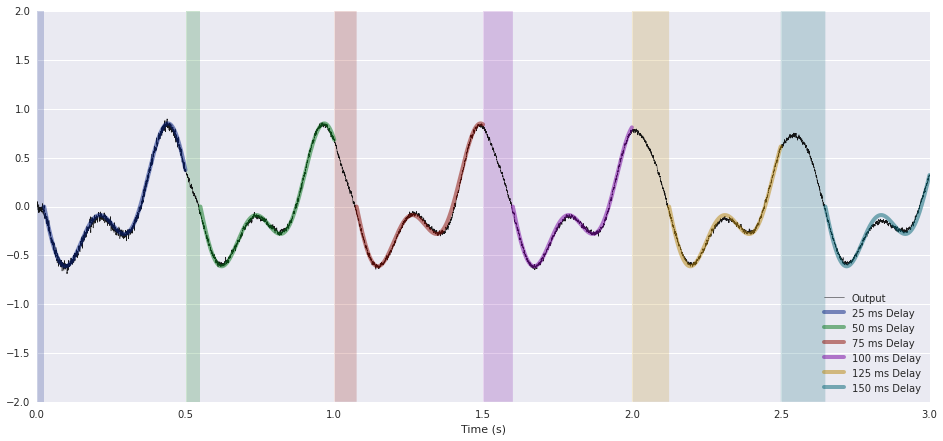

In [5]:
ylow = -2.0
yhigh = 2.0
ones = np.ones_like(sim.trange())
pal = sns.color_palette("dark", len(gains))

pylab.figure(figsize=(16, 7))
pylab.plot(sim.trange(), sim.data[p_output], lw=0.5, alpha=0.9, c='black', label="Output")

for i, u in enumerate(gains):
    mod_delay = delay / (1 + u)
    delayed = nengolib.synapses.PureDelay(int(mod_delay / dt)).filt(sim.data[p_stim], dt=dt)

    sl = (sim.trange() >= i*period + mod_delay) & (sim.trange() < (i+1)*period)
    pylab.plot(sim.trange()[sl], delayed[sl], label="%d ms Delay" % (mod_delay * 1000 + 1e-12), lw=4, alpha=0.5, c=pal[i])
    
    sl = (sim.trange() > i*period) & (sim.trange() <= i*period + mod_delay)
    pylab.fill_between(sim.trange()[sl], ylow*ones[sl], yhigh*ones[sl], alpha=0.2, lw=0, facecolor=pal[i])

pylab.ylim(ylow, yhigh)
pylab.legend(loc='lower right')
pylab.xlabel("Time (s)")
pylab.show()

In [39]:
neuron_type = nengo.LIFRate()
input_synapse = nengo.Alpha(0.001)
synapse = 0.02

trajectory = np.asarray([0, 0.5, 1.0, 0, -1.0, -0.5, 0.5, 0.3, 0.1, 0])
trajectory_dt = 0.01

delay = len(trajectory) * trajectory_dt
diffs = np.asarray([-0.050, -0.025, 0.000, 0.025, 0.050, 0.075][::-1])
gains = delay / (delay + diffs) - 1  # convert time difference to inverse gain

box_period = 2 * delay
box_width = 50 * dt
box_amplitude = 0.01 / box_width

with nengolib.Network(seed=seed) as model:
    sys = PadeDelay(3, 4, delay)
    #sys = nengolib.signal.LinearSystem((sys.A - 1000.0*np.eye(len(sys)), sys.B, sys.C, sys.D))
    subnet = ControlledLinearNetwork(
        sys, n_neurons=2000, neuron_type=neuron_type,
        synapse=synapse, input_synapse=None, control_radius=max(abs(gains)),
        radii=1.0, dt=None, solver=LstsqL2(reg=0.1))

fir_length = 3 * len(trajectory)
eval_points = np.empty((len(gains) * fir_length, subnet.size_state + 1))
targets = np.zeros((len(gains) * fir_length, 1))

for i, u in enumerate(gains):    
    targets[i * len(trajectory):(i + 1) * len(trajectory)] = trajectory[:, None]
    fir_sl = slice(i * fir_length, (i + 1) * fir_length)
    eval_points[fir_sl, -1] = u
    
    s = np.poly1d([1.0 / (1 + u), 1.0])  # substitute s / (1 + u) into tf
    for j, subsys in enumerate(nengolib.signal.decompose_states(subnet.normalized)):
        H = nengolib.LinearFilter(subsys.num(s), subsys.den(s))
        r = nengolib.signal.impulse(H, trajectory_dt, fir_length) * trajectory_dt
        eval_points[fir_sl, j] = r

with model:
    stim = nengo.Node(output=lambda t: int(((t - dt) % box_period) < box_width) * box_amplitude)
    control = nengo.Node(output=PresentInput(gains, period))
    output = nengo.Node(size_in=1)
    
    nengo.Connection(stim, subnet.input, synapse=input_synapse)
    nengo.Connection(control, subnet.control, synapse=None)
    
    # check out nengo branch: "function-points"
    nengo.Connection(subnet.x, output, eval_points=eval_points, function=targets, synapse=0.01)
    
    p_stim = nengo.Probe(stim, synapse=input_synapse)
    p_control = nengo.Probe(control, synapse=None)
    p_output = nengo.Probe(output, synapse=None)
    p_x = nengo.Probe(subnet.x, synapse=synapse)

In [40]:
with nengo.Simulator(model, dt=dt, seed=seed) as sim:
    sim.run(len(gains) * box_period)

Simulation finished in 0:00:03.                                                 


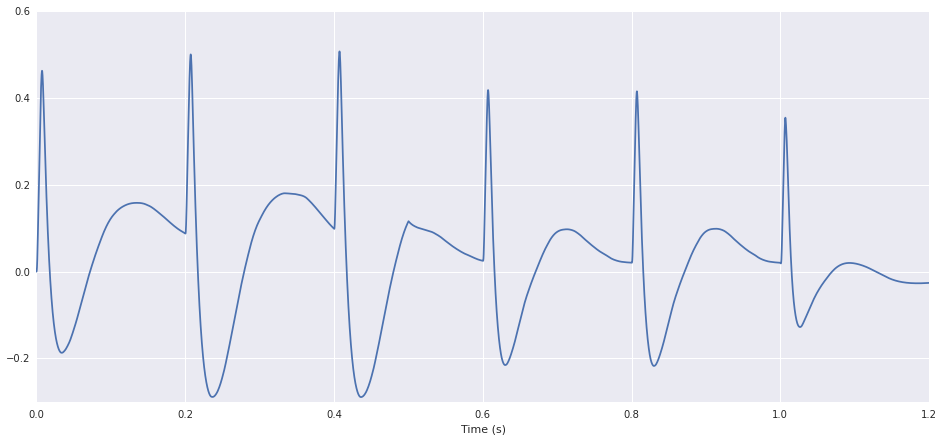

In [41]:
'''
pylab.figure()
pylab.plot(sim.trange(), sim.data[p_x][:, :-1])
pylab.show()

pylab.figure()
pylab.plot(sim.trange(), sim.data[p_stim])
pylab.show()

pylab.figure()
pylab.plot(sim.trange(), sim.data[p_control])
pylab.show()
'''

pylab.figure(figsize=(16, 7))
pylab.plot(sim.trange(), sim.data[p_output])
pylab.xlabel("Time (s)")
pylab.show()